In [62]:
import torch
import os
import torch.nn.init as init
from torchvision import datasets, transforms
from torch import optim, nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [63]:
num_epochs = 4
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

In [65]:
def task_dataloader(task_num):
    task_dir = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4:[8, 9]}

    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=tf)

    indices = [i for i, (_, label) in enumerate(train_dataset) if label in task_dir[task_num]]
    dataset = Subset(train_dataset, indices)
    task_train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    indices = [i for i, (_, label) in enumerate(test_dataset) if label in task_dir[task_num]]
    dataset = Subset(test_dataset, indices)
    task_test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return task_train_loader, task_test_loader

def load_all_data():
    train_dataset = datasets.MNIST(root='./data', train=True, transform=tf, download=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = datasets.MNIST(root='./data', train=False, transform=tf, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [66]:
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.75 * param_group['lr']

In [67]:
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super(MLP_Enhance, self).__init__()
        self.in_dim = in_channel*img_sz*img_sz
        self.linear = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.last = nn.Sequential(
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax(dim=1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(layer.bias, 0)
        last_linear = self.last[0]
        init.xavier_normal_(last_linear.weight)
        init.constant_(last_linear.bias, 0)


    def features(self, x):
        x = self.linear(x.view(-1,self.in_dim))
        return x

    def logits(self, x):
        x = self.last(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [68]:
train_loader, test_loader = load_all_data()
task_dataloaders = {}
for task in range(0, 5):
    train_dl, test_ld = task_dataloader(task)
    task_dataloaders[task] = (train_dl, test_ld)

# Train

In [69]:
def cal_acc(model, dataloader, device):
    model.eval()
    correct, total = 0., 0.
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

## Distribution Loss

In [70]:
def train_distribution(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]

    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            except_mean = 0.2
            empty_loss = 0
            for task in range (5):
                    task_start = task * 2
                    task_end = (task + 1) * 2

                    fake_image = torch.randn(batch_size, 1, 28, 28)
                    fake_output = follower(fake_image)

                    real_mean = torch.mean(torch.abs(fake_output[:,task_start:task_end]))
                    empty_loss += torch.abs(except_mean - real_mean)
            

            loss = criterion(outputs[:,:valid_out_dim], labels) + empty_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()


        adjust_learning_rate(optimizer_F)
        avg_acc = 0
        for task in range(task_num + 1):
            acc = cal_acc(follower, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            print(f"Task {task} acc: { acc * 100:.4f}", end = ', ')
            
        print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

    
    return follower, task_accuracies

In [71]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_0 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_distribution(model, task, criterion, 5)
    all_accuracies_0.append(accuracies)

##########Task 0##########
Epoch 0
Task 0 acc: 93.6464, Task avg acc:93.6464
Epoch 1
Task 0 acc: 95.6314, Task avg acc:95.6314
Epoch 2
Task 0 acc: 95.1052, Task avg acc:95.1052
Epoch 3
Task 0 acc: 94.6668, Task avg acc:94.6668
Epoch 4
Task 0 acc: 94.1008, Task avg acc:94.1008
##########Task 1##########
Epoch 0
Task 0 acc: 0.0159, Task 1 acc: 92.3703, Task avg acc:46.1931
Epoch 1
Task 0 acc: 0.0080, Task 1 acc: 95.0715, Task avg acc:47.5397
Epoch 2
Task 0 acc: 0.0159, Task 1 acc: 94.2736, Task avg acc:47.1448
Epoch 3
Task 0 acc: 0.0000, Task 1 acc: 94.0575, Task avg acc:47.0288
Epoch 4
Task 0 acc: 0.0000, Task 1 acc: 95.5701, Task avg acc:47.7851
##########Task 2##########
Epoch 0
Task 0 acc: 0.0000, Task 1 acc: 0.0000, Task 2 acc: 85.7938, Task avg acc:28.5979
Epoch 1
Task 0 acc: 0.0000, Task 1 acc: 0.0000, Task 2 acc: 85.6412, Task avg acc:28.5471
Epoch 2
Task 0 acc: 0.0000, Task 1 acc: 0.0000, Task 2 acc: 88.0298, Task avg acc:29.3433
Epoch 3
Task 0 acc: 0.0000, Task 1 acc: 0.0000, T

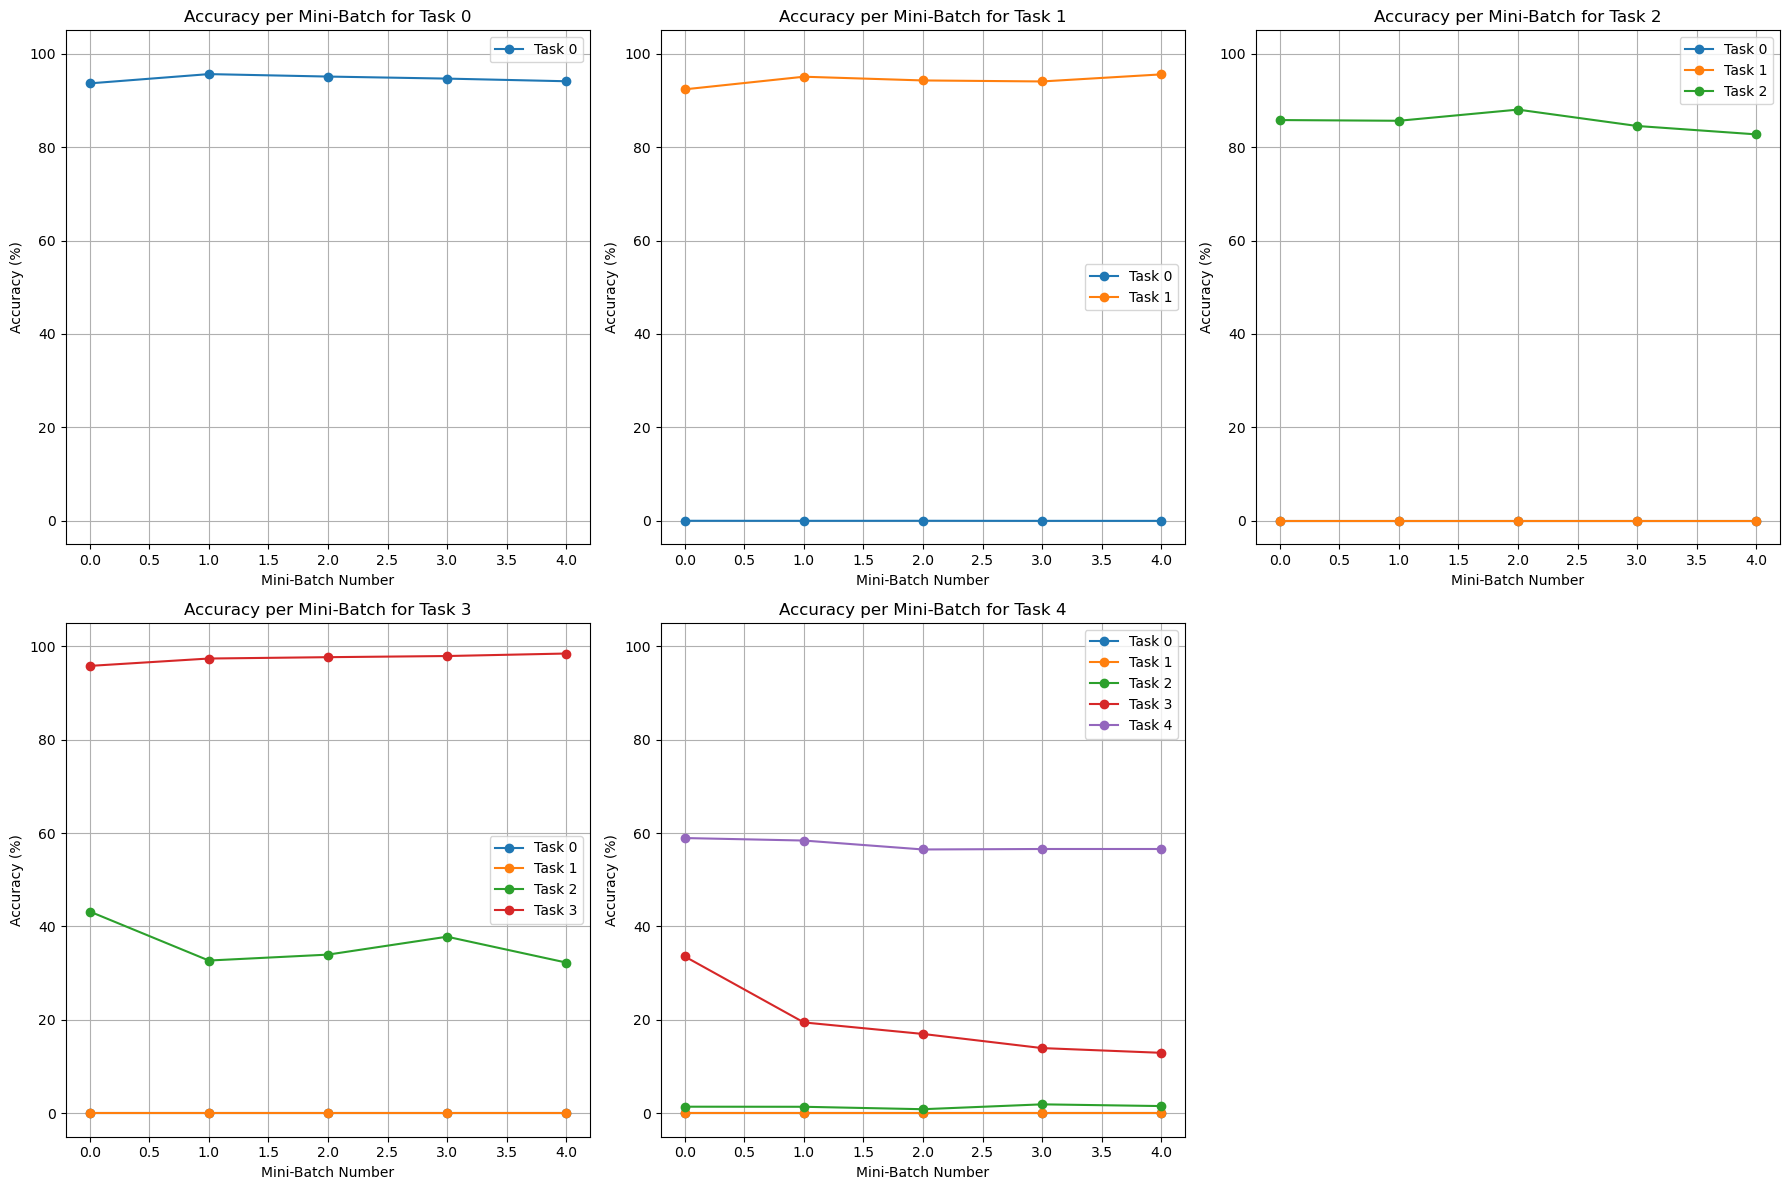

In [72]:
plt.figure(figsize=(18, 12))

for i, task_accuracies in enumerate(all_accuracies_0):
    plt.subplot(2, 3, i+1)
    for task, accs in task_accuracies.items():
        plt.plot(accs,'o-', label=f'Task {task}')
    plt.title(f'Accuracy per Mini-Batch for Task {i}')
    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## Forward Task Loss

In [79]:
def train_forward_task(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)


            with torch.no_grad():
                leader_output = model(images)

            if (task_num == 0):
                diff_loss =  0
            else:
                diff_loss =  4 * torch.mean(torch.abs(leader_output[:,:valid_out_dim - 2] - outputs[:,:valid_out_dim - 2]))

            loss = criterion(outputs[:,:valid_out_dim], labels) + diff_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

        adjust_learning_rate(optimizer_F)
        avg_acc = 0
        for task in range(task_num + 1):
            acc = cal_acc(follower, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            print(f"Task {task} acc: { acc * 100:.4f}", end = ', ')
            
        print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")

    
    return follower, task_accuracies

In [80]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_1 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_forward_task(model, task, criterion, 5)
    all_accuracies_1.append(accuracies)

##########Task 0##########
Epoch 0
Task 0 acc: 99.9442, Task avg acc:99.9442
Epoch 1
Task 0 acc: 99.9362, Task avg acc:99.9362
Epoch 2
Task 0 acc: 99.9601, Task avg acc:99.9601
Epoch 3
Task 0 acc: 99.9681, Task avg acc:99.9681
Epoch 4
Task 0 acc: 99.9841, Task avg acc:99.9841
##########Task 1##########
Epoch 0
Task 0 acc: 99.9761, Task 1 acc: 6.2001, Task avg acc:53.0881
Epoch 1
Task 0 acc: 99.9681, Task 1 acc: 8.6852, Task avg acc:54.3266
Epoch 2
Task 0 acc: 99.9681, Task 1 acc: 6.4079, Task avg acc:53.1880
Epoch 3
Task 0 acc: 99.9601, Task 1 acc: 4.2719, Task avg acc:52.1160
Epoch 4
Task 0 acc: 99.9761, Task 1 acc: 4.6459, Task avg acc:52.3110
##########Task 2##########
Epoch 0
Task 0 acc: 84.7577, Task 1 acc: 0.0499, Task 2 acc: 54.3463, Task avg acc:46.3846
Epoch 1
Task 0 acc: 87.8268, Task 1 acc: 0.1496, Task 2 acc: 67.0708, Task avg acc:51.6824
Epoch 2
Task 0 acc: 95.3205, Task 1 acc: 0.2493, Task 2 acc: 72.8807, Task avg acc:56.1502
Epoch 3
Task 0 acc: 96.2612, Task 1 acc: 0.232

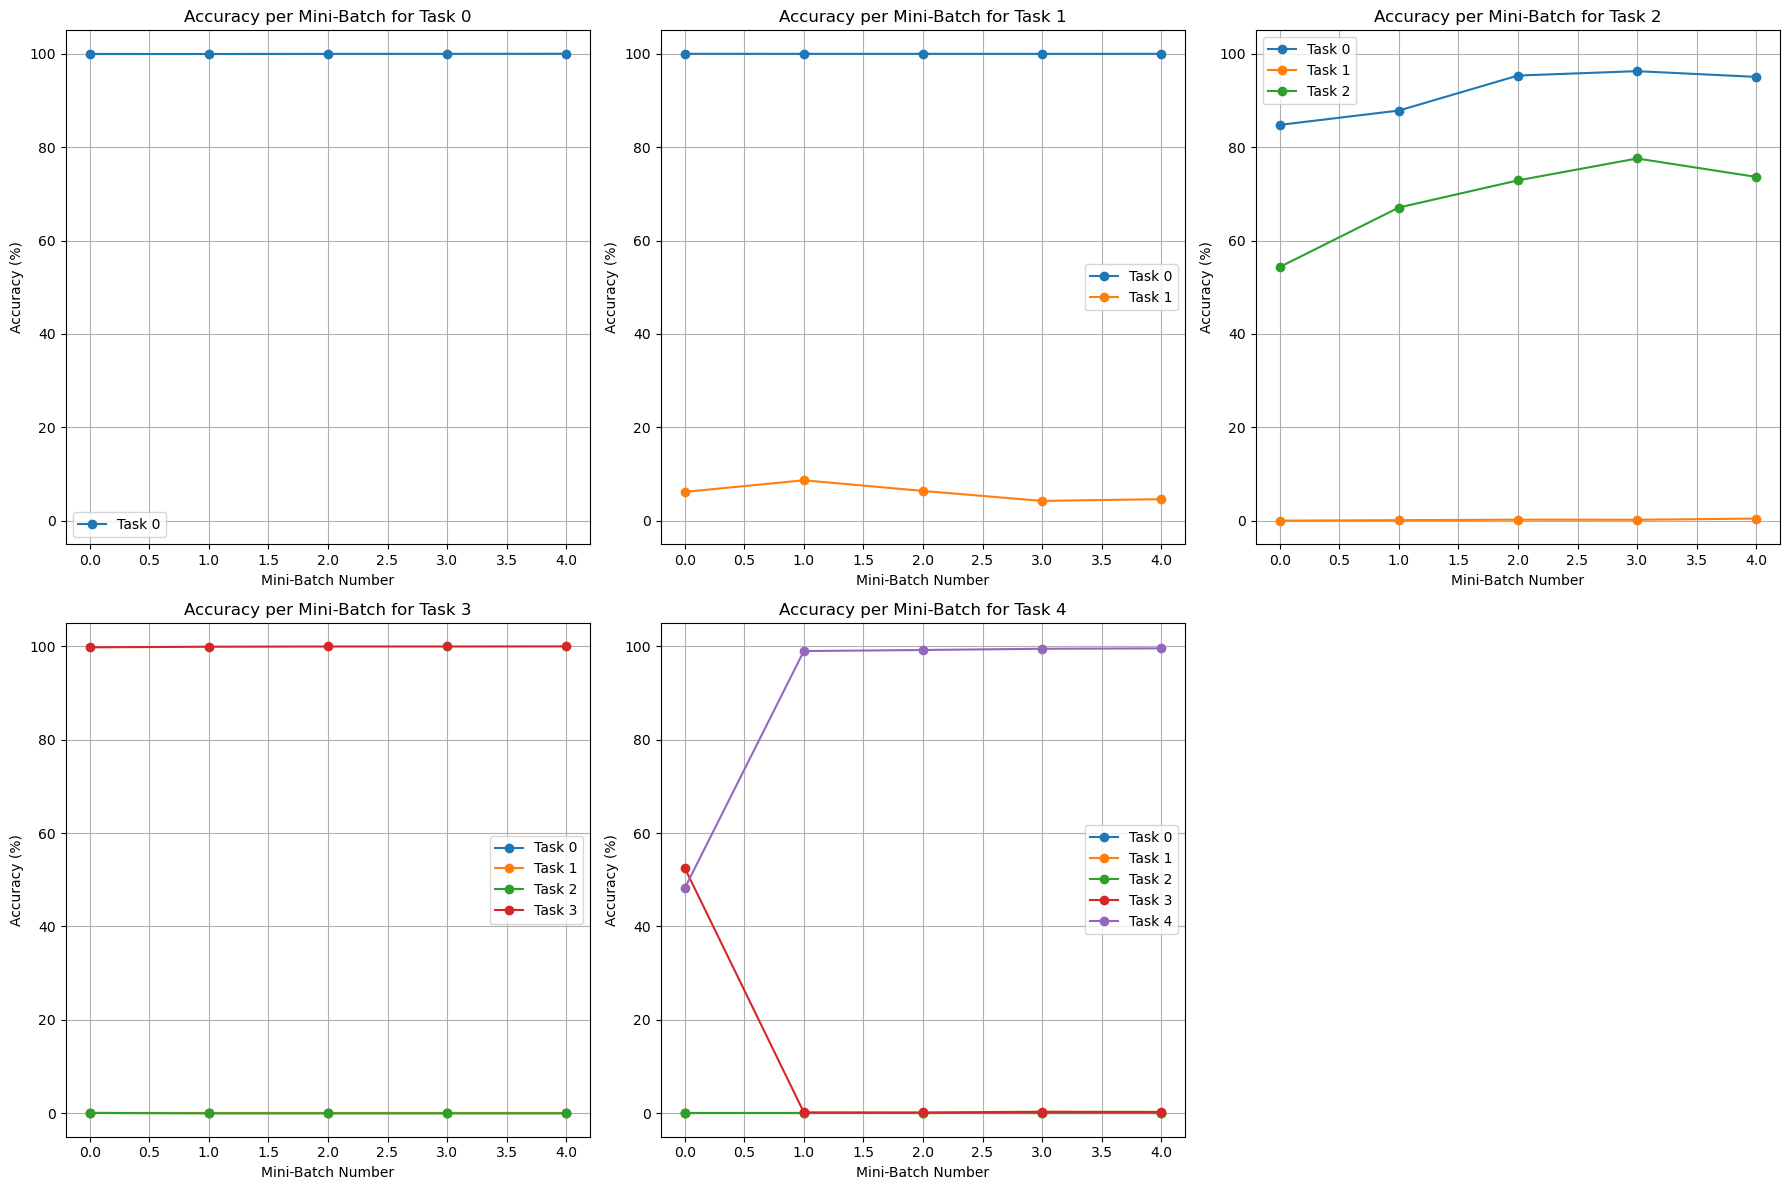

In [81]:
plt.figure(figsize=(18, 12))

for i, task_accuracies in enumerate(all_accuracies_1):
    plt.subplot(2, 3, i+1) 
    for task, accs in task_accuracies.items():
        plt.plot(accs,'o-', label=f'Task {task}')
    plt.title(f'Accuracy per Mini-Batch for Task {i}')
    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Interupt Loss

In [82]:
def train_interupt(model, task_num, criterion, epoches):
    follower = MLP_Enhance()
    follower = follower.to(device)
    follower.load_state_dict(model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer_F = torch.optim.Adam(follower.parameters(), 0.001)
    train_loader = task_dataloaders[task_num][0]
    task_accuracies = {task: [] for task in range(task_num + 1)}

    valid_out_dim = task_num * 2 + 2
    print(f"##########Task {task_num}##########")
    for e in range(epoches):
        print(f"Epoch {e}")

        for images, labels in train_loader:
            follower.train()
            images, labels = images.to(device), labels.to(device)
            outputs = follower(images)

            interupt_loss = 0
            for i in range (4):
                fake_image = torch.randn(batch_size, 1, 28, 28)

                with torch.no_grad():
                    leader_fake_output = model(fake_image)
                
                fake_outputs = follower(images)

                if (task_num == 0):
                    interupt_loss =  0
                else:
                    interupt_loss += torch.mean(torch.abs(leader_fake_output - fake_outputs))

            loss = criterion(outputs[:,:valid_out_dim], labels) + 0.65 * interupt_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

        adjust_learning_rate(optimizer_F)
        avg_acc = 0
        for task in range(task_num + 1):
            acc = cal_acc(follower, task_dataloaders[task][0], device)
            avg_acc += acc
            task_accuracies[task].append(acc * 100)
            print(f"Task {task} acc: { acc * 100:.4f}", end = ', ')
        
        print(f"Task avg acc:{avg_acc*100/(task_num + 1):.4f}")
    
    return follower, task_accuracies

In [83]:
model = MLP_Enhance()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

all_accuracies_3 = []
for task in [0, 1, 2, 3, 4]:
    model, accuracies = train_interupt(model, task, criterion, 5)
    all_accuracies_3.append(accuracies)

##########Task 0##########
Epoch 0
Task 0 acc: 99.9522, Task avg acc:99.9522
Epoch 1
Task 0 acc: 99.9522, Task avg acc:99.9522
Epoch 2
Task 0 acc: 99.9522, Task avg acc:99.9522
Epoch 3
Task 0 acc: 99.9681, Task avg acc:99.9681
Epoch 4
Task 0 acc: 99.9681, Task avg acc:99.9681
##########Task 1##########
Epoch 0
Task 0 acc: 1.6183, Task 1 acc: 98.0136, Task avg acc:49.8160
Epoch 1
Task 0 acc: 1.2277, Task 1 acc: 98.8198, Task avg acc:50.0237
Epoch 2
Task 0 acc: 0.7653, Task 1 acc: 99.0858, Task avg acc:49.9255
Epoch 3
Task 0 acc: 0.5580, Task 1 acc: 99.2686, Task avg acc:49.9133
Epoch 4
Task 0 acc: 0.7175, Task 1 acc: 99.3517, Task avg acc:50.0346
##########Task 2##########
Epoch 0
Task 0 acc: 0.0000, Task 1 acc: 1.2217, Task 2 acc: 99.1290, Task avg acc:33.4502
Epoch 1
Task 0 acc: 0.0000, Task 1 acc: 0.4904, Task 2 acc: 99.6049, Task avg acc:33.3651
Epoch 2
Task 0 acc: 0.0000, Task 1 acc: 0.4156, Task 2 acc: 99.7216, Task avg acc:33.3791
Epoch 3
Task 0 acc: 0.0000, Task 1 acc: 0.4654, T

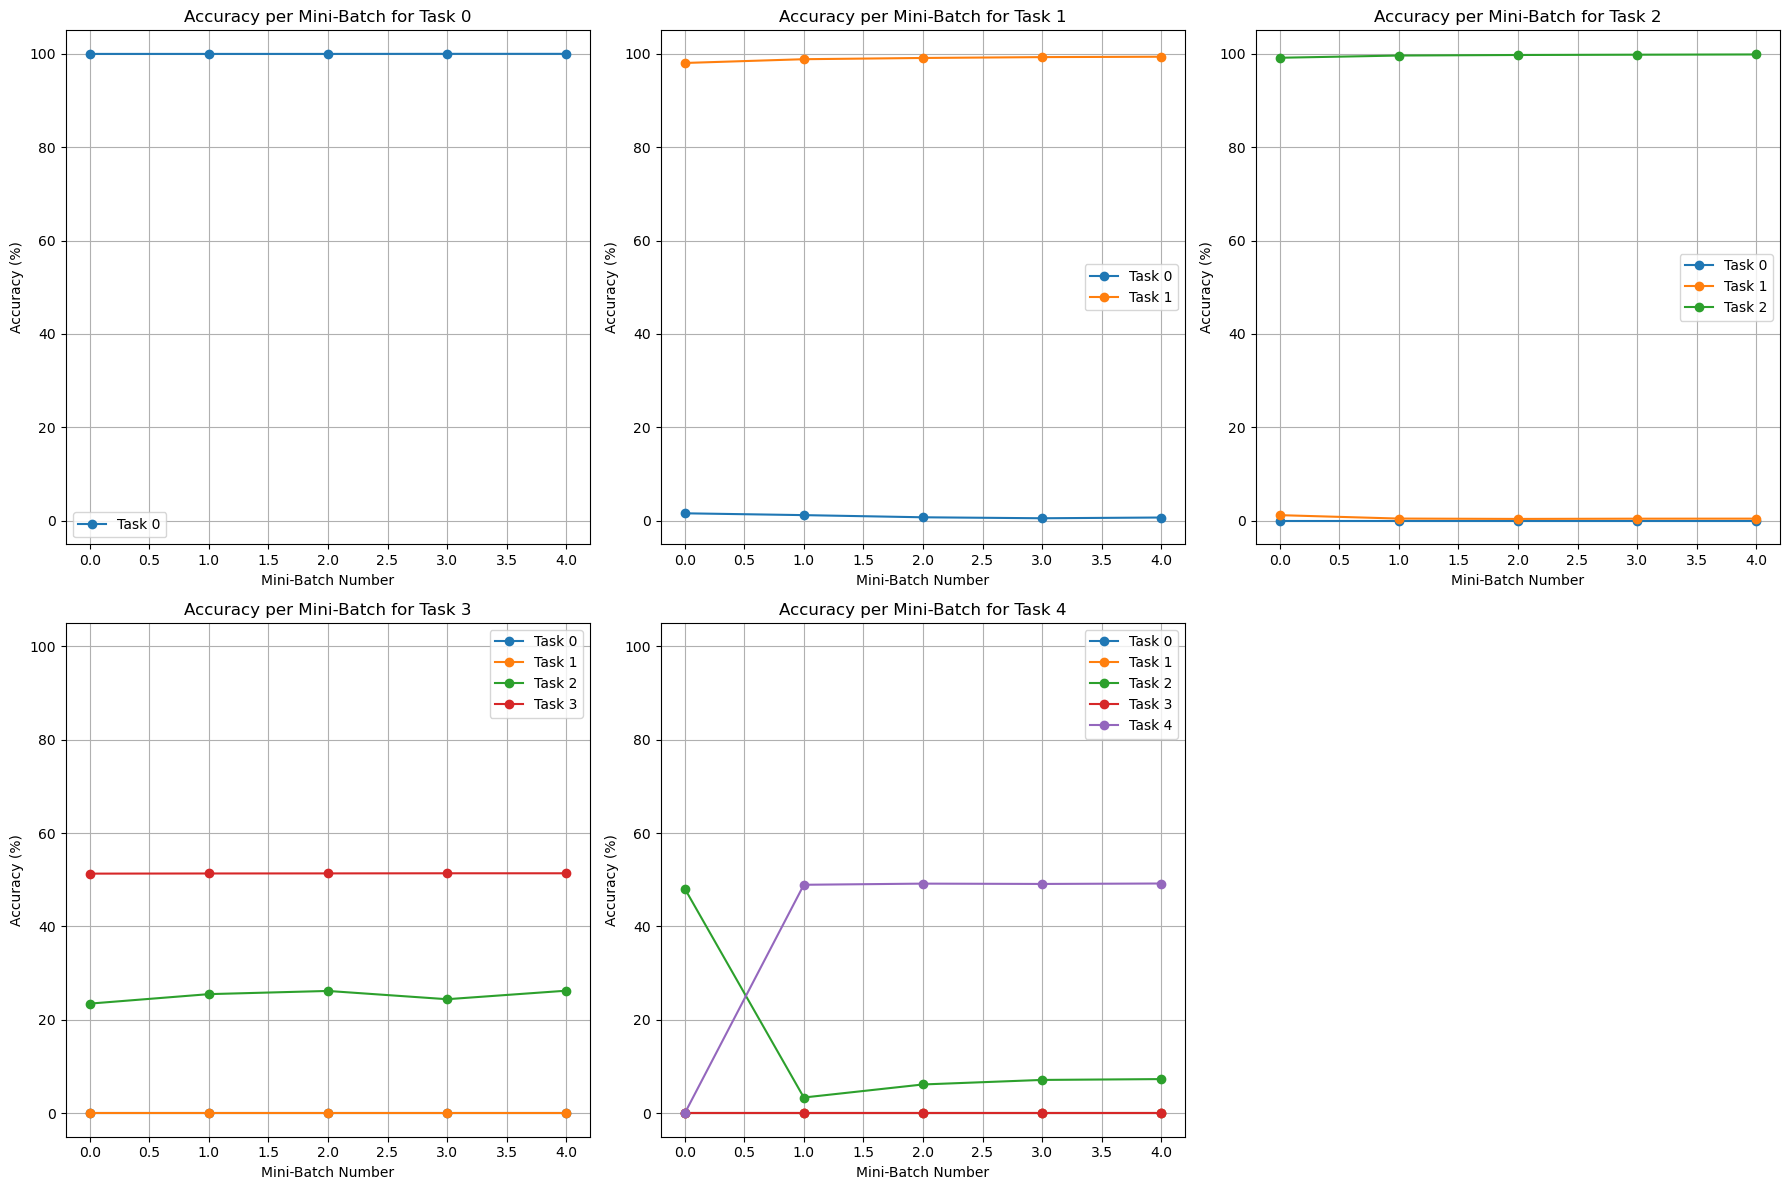

In [84]:
plt.figure(figsize=(18, 12))

for i, task_accuracies in enumerate(all_accuracies_3):
    plt.subplot(2, 3, i+1) 
    for task, accs in task_accuracies.items():
        plt.plot(accs, 'o-',label=f'Task {task}')
    plt.title(f'Accuracy per Mini-Batch for Task {i}')
    plt.xlabel('Mini-Batch Number')
    plt.ylabel('Accuracy (%)')
    plt.ylim(-5, 105)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()